# Лабораторная работа №2

In [1]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from colorama import Style

## 1) MSBFS-Levels

In [2]:
def MSBFS_Levels(A, start_vertices):
    '''0. Проверка того, что граф является ориентированным'''
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")
        
    '''1. Начальные значения параметров'''
    n = A.nrows # число вершин
    m = start_vertices.size # число стартовых вершин
    result = Matrix(dtypes.INT32, m, n) # размеры результирующей матрицы
    f = Matrix(bool, m, n) # фронт
    succ = Vector(bool, m) # вектор, показывающий доступность вершин из текущей
    
    #в матрице f проставление True в ячейках стартовых вершин
    for i in range(m):
        f[i, start_vertices[i]] << True 
    
    '''2. Обход графа'''
    level = 0
    while True:
        # стартовые вершины заполняются как 0-ой уровень
        result(mask=f.V) << level 
        # расчет следующего фронта (перемножение матриц + маска)
        f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)
        # для каждой стартовой вершины заполнение вектора наличия доступных вершин
        for i in range(m):
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False) 
            
        # проверка критерия остановки цикла while (ни из одной стартовой вершины на очередной итерации нет доступных вершин?)
        finish_flg = True
        for i in range(m):
            # если хотя бы один элемент True, цикл завершаем меняя флаг
            if succ[i]:
                finish_flg = False
                break
                
        # если флаг так и остался True (ни одного срабатывания), то цикл while завершается 
        if finish_flg:
            break
            
        level += 1    
    '''3. Приведение результата к нужному формату'''
    # заполнение недоступных вершин дефолтными значениями (-1)
    # и преобразование результата в следующий формат: словарь, где ключ - номер вершины, значение - массив номеров уровней
    res = result.to_dense(fill_value=-1)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
        
    return output 

## 2) MSBFS-Parents

In [3]:
def MSBFS_Parents(A, start_vertices):
    '''0. Проверка того, что граф является ориентированным'''
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")

    '''1. Начальные значения параметров'''
    N = A.nrows # число вершин
    M = start_vertices.size # число стартовых вершин

    # генерация матрицы, где идентификатор вершины равен значению
    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:,j] << j
        
    parents, wavefront = Matrix(dtypes.INT64, M, N), Matrix(dtypes.UINT64, M, N)
    
    # заполнение стартовыми значениями матриц parents, wavefront
    for i in range(M):
        parents[i, start_vertices[i]] << start_vertices[i] 
        wavefront[i, start_vertices[i]] << 1
        
    '''2. Обход графа'''
    while wavefront.nvals > 0:
        # Преобразование всех сохраненных значений в wavefront в их индекc
        wavefront << index_ramp.ewise_mult(wavefront, binary.first) 
        # маскирование родительского списка
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first) 
        # Объединение новых родительских элементов в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront 
    
    '''3. Приведение результата к нужному формату'''
    # заполнение недоступных вершин дефолтными значениями (-2), для стартовых вершин -1
    # и преобразование результата в следующий формат: словарь, где ключ - номер вершины, значение - массив родительских вершин
    for ind in range(len(start_vertices)):
        parents[ind, start_vertices[ind]] << -1
    
    res = parents.to_dense(fill_value=-2)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
    
    return output 

## 3) Проверка корректности работы функций <code>MSBFS-Levels</code> и  <code>MSBFS-Parents</code>

Всего будет 3 графа для проверки:
- неориентированный граф (проверка того, что отработает ошибка);
- граф со связанными  вершинами  (но не обязательно достижимы из каждой стартовой точки);
- граф, у которого вершины сгруппированы в "островки". 

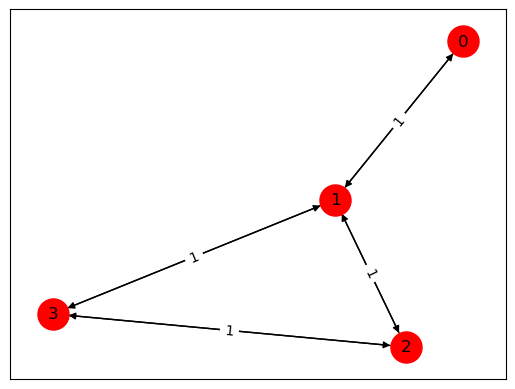

Exception: Error!!! Граф неориентированный!

In [4]:
'''а) Создадим простой неориентированный граф с 4 вершинами и 1 треугольником, в котором участвуют вершины 1, 2 и 3.'''
matrix1 = np.array([
    [0, 1, 0, 0],
    [1, 0, 1, 1],
    [0, 1, 0, 1],
    [0, 1, 1, 0]
])
M1 = gb.Matrix.from_dense(matrix1, missing_value=0)

gb.viz.draw(M1)

print(MSBFS_Levels(M1, np.array([0, 1, 2, 3])))

In [5]:
print(MSBFS_Parents(M1, np.array([0, 1, 2, 3])))

Exception: Error!!! Граф неориентированный!

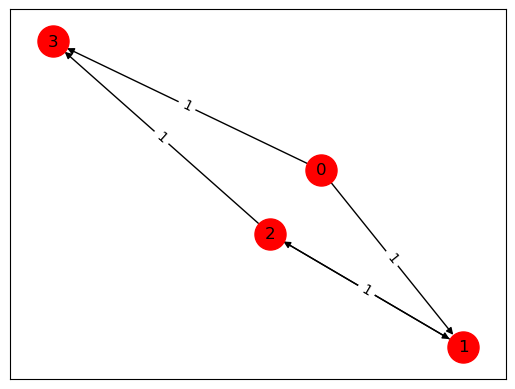

In [6]:
'''б) Создадим простой ориентированный граф с 4 вершинами в форме квадрата'''
matrix2 = np.array([
    [0, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 1],
    [0, 0, 0, 0]
])
M2 = gb.Matrix.from_dense(matrix2, missing_value=0)

gb.viz.draw(M2)

'''начало в вершинах 0, 1, 3'''
##### для уровней
# старт из 0: вершины 1 и 3 - 1го уровня, 2 - 2го уровня
# старт из 1: вершина 2 - 1го уровня, 3 - 2ого уровня, 0 - недостижима
# старт из 3: вершины 0, 1, 2 - недостижимы
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[0]==np.array([0, 1, 2, 1])).all()
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[1]==np.array([-1, 0, 1, 2])).all()
assert (MSBFS_Levels(M2, np.array([0, 1, 3]))[3]==np.array([-1, -1, -1, 0])).all()
##### для родителей
# старт из 0: вершина 1 достижима из 0, 2 - из 1, 3 из 0 и 2 (ближайшая 0)
# старт из 1: вершина 0 недостижима, вершина 2 достижима из 1, вершина 3 достижима из 0 и 2 (ближайшая 2)
# старт из 3: все вершины недостижимы
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[0]==np.array([-1, 0, 1, 0])).all()
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[1]==np.array([-2, -1, 1, 2])).all()
assert (MSBFS_Parents(M2, np.array([0, 1, 3]))[3]==np.array([-2, -2, -2, -1])).all()

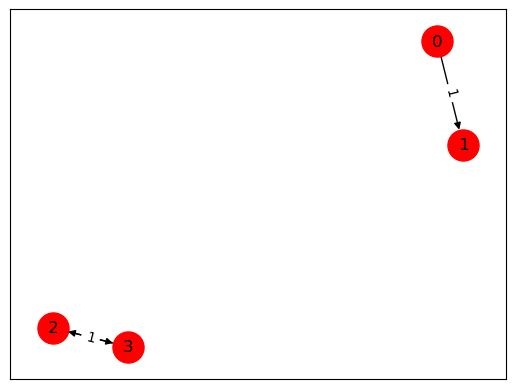

In [7]:
'''в) Создадим граф с 4 вершинами из двух островков'''
matrix3 = np.array([
    [0, 1, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])
M3 = gb.Matrix.from_dense(matrix3, missing_value=0)

gb.viz.draw(M3)

'''начало в вершинах 3, 2, 1'''
##### для уровней
# старт из 3: вершины 0 и 1 - недостижимы, 2 - 1го уровня
# старт из 2: вершины 0 и 1 - недостижимы, 3 - 1го уровня
# старт из 1: вершина 0, 2 и 3 - недостижимы
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[3]==np.array([-1, -1, 1, 0])).all()
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[2]==np.array([-1, -1, 0, 1])).all()
assert (MSBFS_Levels(M3, np.array([3, 2, 1]))[1]==np.array([-1, 0, -1, -1])).all()
##### для родителей
# старт из 3: вершина 0 и 1 недостижима, вершина 2 достижима из 3
# старт из 2: вершина 0 и 1 недостижима, вершина 3 достижима из 2
# старт из 1: вершина 0, 2 и 3 - недостижимы
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[3]==np.array([-2, -2, 3, -1])).all()
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[2]==np.array([-2, -2, -1, 2])).all()
assert (MSBFS_Parents(M3, np.array([3, 2, 1]))[1]==np.array([-2, -1, -2, -2])).all()

## 4) Тестирование на графах с  [SuiteSparse Matrix Collection](https://sparse.tamu.edu)

Было скачано 3 графа.

In [8]:
graph_names = ['GD00_a', 'CSphd', 'EPA'] # названия загруженных графов
vertex_fracs=[5, 35, 70, 95] # доли стартовых вершин от общего числа

In [9]:
'''Функции для тестирования'''

def gen_vertices(num_vertices, vertex_frac):
    '''
    генерация стартовых вершин в зависимости от числа вершин (num_vertices) и 
    доли (в %) стартовых вершин от общего числа (vertex_frac)
    '''
    start_vertices = random.sample(range(num_vertices), int(vertex_frac / 100 * num_vertices))
    return np.array(start_vertices)


# тестирование функции "MSBFS_Levels"
def test_Levels(A, start_vertices):
    print('MSBFS_Levels:')
    %timeit MSBFS_Levels(A, start_vertices)
    print()

    
# тестирование функции "MSBFS_Levels"
def test_Parents(A, start_vertices):
    print('MSBFS_Parents:')
    %timeit MSBFS_Parents(A, start_vertices)
    print('\n')

In [10]:
'''Тестирование функции MSBFS-Levels'''
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'DataLab2/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Levels(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Levels:
30.6 ms ± 2.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество стартовых вершин: 123
MSBFS_Levels:
278 ms ± 20.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 246
MSBFS_Levels:
529 ms ± 43.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
MSBFS_Levels:
763 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Levels:
366 ms ± 31.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 658
MSBFS_Levels:
2.52 s ± 90.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1317
MSBFS_Levels:
6.2 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
'''Тестирование функции MSBFS-Parents'''
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'DataLab2/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Parents(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Parents:
104 ms ± 5.16 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 123
MSBFS_Parents:
145 ms ± 2.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 246
MSBFS_Parents:
185 ms ± 8.19 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 334
MSBFS_Parents:
216 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Parents:
583 ms ± 7.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 658
MSBFS_Parents:
873 ms ± 29.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 1317
MSBFS_Parents:
1.22 s ± 47.2 ms per loop (mean ± std. dev. of 7 

## 5) Тестирование на случайно сгенерированных графах

In [12]:
def generate_graph(num_vertices, num_edges):
    '''создание множества, состоящего из номеров ячеек матрицы (без диагональных элементов)'''
    positions=[]
    for ind in range(num_vertices**2):
        if ind // num_vertices != ind % num_vertices:
            positions.append(ind)

    '''Отбор num_edges случайных индексов вершин (случайные значения из high_positions) для создания ребер'''
    gen_indices = random.sample(positions, num_edges)
    
    '''Преобразование индексов в координаты (строка, столбец)'''
    row_indices, col_indices = np.unravel_index(gen_indices, (num_vertices, num_vertices))
    
    return gb.Matrix.from_coo(row_indices, col_indices, [1]*len(row_indices), nrows=num_vertices, ncols=num_vertices)

#### 5.1) Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)

In [13]:
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(i, num_starts))
    test_Parents(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
62.2 ms ± 1.88 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents:
50.6 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
122 ms ± 7.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents:
108 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
253 ms ± 6.59 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
292 ms ± 23.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels:
564 ms ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
1.05 s ± 75.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


#### 5.2) Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)

In [14]:
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
MSBFS_Levels:
346 ms ± 23.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
256 ms ± 14.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
MSBFS_Levels:
308 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
311 ms ± 24.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
MSBFS_Levels:
322 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
411 ms ± 20.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
MSBFS_Levels:
329 ms ± 18 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
352 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)




#### 5.3) Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)

In [15]:
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test_Levels(generated_graph, gen_vertices(num_vert, i))
    test_Parents(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Levels:
139 ms ± 9.97 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents:
263 ms ± 10.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Levels:
271 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
361 ms ± 8.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Levels:
395 ms ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
485 ms ± 25.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
MSBFS_Levels:
517 ms ± 31.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents:
573 ms ± 46.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)




#### 5.4) Выводы

- С ростом числа вершин (при степени разреженности = 0.5 и числе стартовых вершин = 50%) увеличивается время работы обоих алгоритмов. Это связано с тем, что увеличивается количество столбцов матриц, что влечет к усложнению произведения матричного умножения. Стоит отметить, что зависимость времени для алгоритма MSBFS_Levels от числа вершин примерно линейная, в то время как для второго алгоритма зависимость уже является степенной.

- При увеличении числа стартовых вершин (при фиксированном числе вершин = 500 и степени разреженности = 50%) также можно отметить увеличение времени работы алгоритмов, в обоих случаях зависимость близка к линейной. Это объясняется всё тем же "удорожанием" матричного умножения, т.к. увеличение числа стартовых вершин напрямую сказывается на строковой размерности фронта.

- При увеличении степени разреженности (при уплотнении графа) какой-то явной зависимости выявлено не было. Более того, по результатам тестов получилось так, что алгоритмы работают быстрее на графах со средней степенью разреженности. В целом, это можно назвать логичным, поскольку алгоритмы адаптируются под реальные графы, а на практике очень редко можно встретить практически полные или совсем разреженные графы.

- Что касается сравнения время работы алгоритмов друг с другом, то тут можно сказать следующее: с увеличением размеров графа MSBFS_Parents всё более явно начинает дольше работать, нежели MSBFS_Levels.

##  6) Реализации алгоритмов с использованием других полуколец  (<code>any.pair</code> для levels и <code>any.first</code> для parents)

Все, что меняется в функциях, это то, что изменяется полукольцо в параметре semiring на any_pair и any_first.

In [16]:
def MSBFS_Levels_anypair(A, start_vertices):
    '''0. Проверка того, что граф является ориентированным'''
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")
        
    '''1. Начальные значения параметров'''
    n = A.nrows # число вершин
    m = start_vertices.size # число стартовых вершин
    result = Matrix(dtypes.INT32, m, n) # размеры результирующей матрицы
    f = Matrix(bool, m, n) # фронт
    succ = Vector(bool, m) # вектор, показывающий доступность вершин из текущей
    
    #в матрице f проставление True в ячейках стартовых вершин
    for i in range(m):
        f[i, start_vertices[i]] << True 
    
    '''2. Обход графа'''
    level = 0
    while True:
        # стартовые вершины заполняются как 0-ой уровень
        result(mask=f.V) << level 
        # расчет следующего фронта (перемножение матриц + маска)
        '''полукольцо any_pair'''
        f(~result.S, replace=True) << f.mxm(A, semiring.any_pair) 
        # для каждой стартовой вершины заполнение вектора наличия доступных вершин
        for i in range(m):
            succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False) 
            
        # проверка критерия остановки цикла while (ни из одной стартовой вершины на очередной итерации нет доступных вершин?)
        finish_flg = True
        for i in range(m):
            # если хотя бы один элемент True, цикл завершаем меняя флаг
            if succ[i]:
                finish_flg = False
                break
                
        # если флаг так и остался True (ни одного срабатывания), то цикл while завершается 
        if finish_flg:
            break
            
        level += 1    
    '''3. Приведение результата к нужному формату'''
    # заполнение недоступных вершин дефолтными значениями (-1)
    # и преобразование результата в следующий формат: словарь, где ключ - номер вершины, значение - массив номеров уровней
    res = result.to_dense(fill_value=-1)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
        
    return output 

In [17]:
def MSBFS_Parents_anyfirst(A, start_vertices):
    '''0. Проверка того, что граф является ориентированным'''
    if A.isequal(A.T) and A.nvals > 0: 
        raise Exception("Error!!! Граф неориентированный!")

    '''1. Начальные значения параметров'''
    N = A.nrows # число вершин
    M = start_vertices.size # число стартовых вершин

    # генерация матрицы, где идентификатор вершины равен значению
    index_ramp = Matrix(dtypes.UINT64, M, N)
    for j in range(N):
        index_ramp[:,j] << j
        
    parents, wavefront = Matrix(dtypes.INT64, M, N), Matrix(dtypes.UINT64, M, N)
    
    # заполнение стартовыми значениями матриц parents, wavefront
    for i in range(M):
        parents[i, start_vertices[i]] << start_vertices[i] 
        wavefront[i, start_vertices[i]] << 1
        
    '''2. Обход графа'''
    while wavefront.nvals > 0:
        # Преобразование всех сохраненных значений в wavefront в их индекc
        wavefront << index_ramp.ewise_mult(wavefront, binary.first) 
        # маскирование родительского списка
        '''полукольцо any_first'''
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.any_first) 
        # Объединение новых родительских элементов в текущий волновой фронт с существующими родителями
        parents(binary.plus) << wavefront 
    
    '''3. Приведение результата к нужному формату'''
    # заполнение недоступных вершин дефолтными значениями (-2), для стартовых вершин -1
    # и преобразование результата в следующий формат: словарь, где ключ - номер вершины, значение - массив родительских вершин
    for ind in range(len(start_vertices)):
        parents[ind, start_vertices[ind]] << -1
    
    res = parents.to_dense(fill_value=-2)
    output = {}
    for i, vert in enumerate(start_vertices):
        output[vert] = res[i, :]
    
    return output 

In [18]:
'''Функции для тестирования'''
# тестирование функции "MSBFS_Levels_anypair"
def test_Levels_anypair(A, start_vertices):
    print('MSBFS_Levels_anypair:')
    %timeit MSBFS_Levels_anypair(A, start_vertices)
    print()

    
# тестирование функции "MSBFS_Levels_anyfirst"
def test_Parents_anyfirst(A, start_vertices):
    print('MSBFS_Parents_anyfirst:')
    %timeit MSBFS_Parents_anyfirst(A, start_vertices)
    print('\n')

## 6.1) Тестирование на тех же графах с  [SuiteSparse Matrix Collection](https://sparse.tamu.edu)


In [19]:
'''Тестирование функции MSBFS-Levels_anypair'''
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'DataLab2/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Levels_anypair(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Levels_anypair:
39.9 ms ± 3.47 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

Количество стартовых вершин: 123
MSBFS_Levels_anypair:
286 ms ± 5.79 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 246
MSBFS_Levels_anypair:
578 ms ± 19.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 334
MSBFS_Levels_anypair:
778 ms ± 27.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Levels_anypair:
427 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 658
MSBFS_Levels_anypair:
2.5 s ± 77.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

Количество стартовых вершин: 1317
MSBFS_Levels_anypair:
5.97 s ± 117

In [20]:
'''Тестирование функции MSBFS-Parents_anyfirst'''
# 1. Зависимость времени работы от размера графа (и степени разреженности)
for graph_name in graph_names:
    graph = mmread(f'DataLab2/{graph_name}.mtx')
    num_vertices = graph.shape[0]
    num_edges = len(graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Для {graph_name}.mtx (Количество вершин: {num_vertices}, количество ребер: {num_edges}), степень разреженности: {rerefaction_deg:.4f}')
    print(Style.RESET_ALL, end='')
    
    # 2. Зависимость времени работы от числа стартовых вершин
    for vertex_frac in vertex_fracs:
        print(f'Количество стартовых вершин: {int(vertex_frac / 100 * graph.nrows)}')
        test_Parents_anyfirst(graph, gen_vertices(graph.nrows, vertex_frac))
    print()

Для GD00_a.mtx (Количество вершин: 352, количество ребер: 458), степень разреженности: 0.0037
Количество стартовых вершин: 17
MSBFS_Parents_anyfirst:
103 ms ± 7.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 123
MSBFS_Parents_anyfirst:
145 ms ± 1.09 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 246
MSBFS_Parents_anyfirst:
199 ms ± 13.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество стартовых вершин: 334
MSBFS_Parents_anyfirst:
223 ms ± 8.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)



Для CSphd.mtx (Количество вершин: 1882, количество ребер: 1740), степень разреженности: 0.0005
Количество стартовых вершин: 94
MSBFS_Parents_anyfirst:
587 ms ± 22.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 658
MSBFS_Parents_anyfirst:
872 ms ± 31.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество стартовых вершин: 1317
MSBFS_Pare

## 6.2) Тестирование на случайно сгенерированных графах

#### 6.2.1) Зависимость от числа вершин (при фикс степени разреженности и фикс числе стартовых вершин)

In [21]:
for i in [100, 200, 400, 800]:
    fix_raref_deg, num_starts = 0.5, 50 # фиксированные значения степени разреженности и числа стартовых вершин
    generated_graph = generate_graph(i, int(fix_raref_deg * i * (i-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(i, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(i, num_starts))

Количество вершин: 100, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
62.4 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents_anyfirst:
48.5 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 200, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
123 ms ± 3.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents_anyfirst:
106 ms ± 2.79 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Количество вершин: 400, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
256 ms ± 6.77 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
287 ms ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 800, степень разреженности: 0.50, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
556 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
1

#### 6.2.2) Зависимость от степени разреженности (при фикс числе вершин и фикс числе стартовых вершин)

In [22]:
for i in [0.2, 0.4, 0.6, 0.8]:
    num_vert, num_starts = 500, 50 # фиксированные число вершин и число стартовых вершин
    generated_graph = generate_graph(num_vert, int(i * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {num_starts}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, num_starts))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, num_starts))

Количество вершин: 500, степень разреженности: 0.20, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
339 ms ± 44.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
268 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.40, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
320 ms ± 13 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
297 ms ± 25.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.60, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
324 ms ± 4.86 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents_anyfirst:
392 ms ± 16.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.80, доля стартовых вершин: 50%
MSBFS_Levels_anypair:
314 ms ± 14.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
332 ms ± 3

#### 6.2.3) Зависимость от числа стартовых вершин (при фикс числе вершин и фикс степени разреженности)

In [23]:
for i in [20, 40, 60, 80]:
    num_vert, fix_raref_deg = 500, 0.5 # фиксированные число вершин и значение степени разреженности
    generated_graph = generate_graph(num_vert, int(fix_raref_deg * num_vert * (num_vert-1)))
    num_vertices = generated_graph.shape[0]
    num_edges = len(generated_graph.to_coo()[0])
    rerefaction_deg = num_edges / (num_vertices * (num_vertices - 1))
    print(Style.BRIGHT + f'Количество вершин: {num_vertices}, степень разреженности: {rerefaction_deg:.2f}, доля стартовых вершин: {i}%')
    print(Style.RESET_ALL, end='')
    test_Levels_anypair(generated_graph, gen_vertices(num_vert, i))
    test_Parents_anyfirst(generated_graph, gen_vertices(num_vert, i))

Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 20%
MSBFS_Levels_anypair:
136 ms ± 2.43 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)

MSBFS_Parents_anyfirst:
259 ms ± 11.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 40%
MSBFS_Levels_anypair:
263 ms ± 18.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
353 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 60%
MSBFS_Levels_anypair:
403 ms ± 32.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
446 ms ± 19.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Количество вершин: 500, степень разреженности: 0.50, доля стартовых вершин: 80%
MSBFS_Levels_anypair:
533 ms ± 33.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

MSBFS_Parents_anyfirst:
544 ms ±

**Выводы**

При сравнении алгоритмов с различными полукольцами можно сделать вывод о том, что в целом время отработки алгоритмов практически не изменилось. Однако есть небольшое отличие: можно заметить, что в крайних случаях (небольшие графы / очень разреженные / очень плотные/ небольшое число стартовых вершин) алгоритмы в начальном кольце работает чуть-чуть. 